Import Liraries

In [6]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)

import warnings;warnings.simplefilter('ignore')
print('Tensorflow version :', tf.__version__)

Tensorflow version : 1.14.0


Load and preprocess data

In [11]:
train_images = pd.read_csv('C:/Users/etudiant/Downloads/image dataset/dataset/train/images.csv', header= None)
train_labels = pd.read_csv('C:/Users/etudiant/Downloads/image dataset/dataset/train/labels.csv', header= None)

val_images = pd.read_csv('C:/Users/etudiant/Downloads/image dataset/dataset/validation/images.csv', header= None)
val_labels = pd.read_csv('C:/Users/etudiant/Downloads/image dataset/dataset/validation/labels.csv', header= None)


In [51]:
val_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [52]:
print('training shape: ' ,train_images.shape, train_labels.shape)
print('validation shape: ' ,val_images.shape, val_labels.shape)


training shape:  (3200, 8192) (3200, 4)
validation shape:  (800, 8192) (800, 4)


In [53]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

PLOT 2-D SPECTROGRAMS

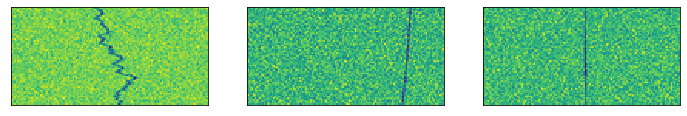

In [54]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img=np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

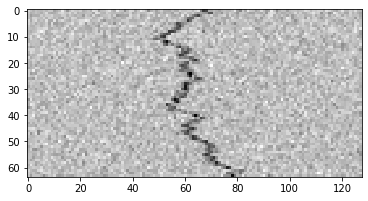

In [55]:
#for gray image
plt.imshow(np.squeeze(x_train[3]), cmap= 'gray')

### Create Training and validation data generators


In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

Creating CNN

In [57]:
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [59]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(64, 128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

Learning Rate scheduling and compil the model


In [60]:
initial_learning_rate= 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)
optimizer= Adam(learning_rate =lr_schedule)

In [61]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 128, 32)       128       
_________________________________________________________________
activation_13 (Activation)   (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 64, 64)       

Training model

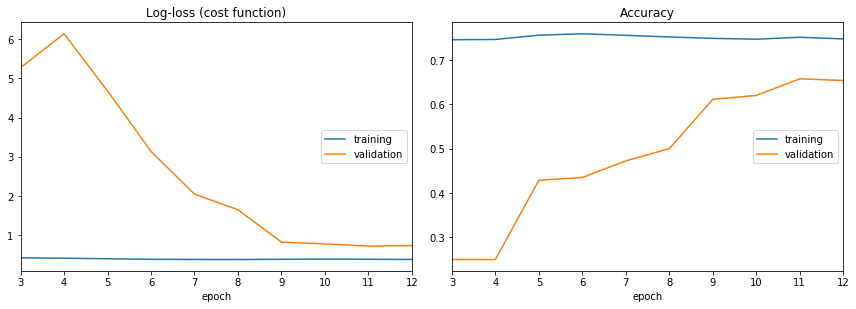

Log-loss (cost function):
training   (min:    0.372, max:    0.692, cur:    0.373)
validation (min:    0.715, max:    6.142, cur:    0.728)

Accuracy:
training   (min:    0.668, max:    0.759, cur:    0.748)
validation (min:    0.250, max:    0.658, cur:    0.654)
100/100 [==============================] - 240s 2s/step - loss: 0.3732 - acc: 0.7475 - val_loss: 0.7285 - val_acc: 0.6538


In [62]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [PlotLossesCallback(), checkpoint]#, reduce_lr]
batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=callbacks
)

Model Evaluation


In [63]:
model.evaluate(x_val,y_val)

800/800 [==============================] - 74s 93ms/sample - loss: 0.7245 - acc: 0.6438


[0.7245197796262801, 0.64375]

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true=np.argmax(y_val, 1)
y_pred= np.argmax(model.predict(x_val),1)
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72       200
           1       0.37      0.27      0.31       200
           2       0.44      0.74      0.55       200
           3       1.00      0.99      1.00       200

    accuracy                           0.64       800
   macro avg       0.70      0.64      0.65       800
weighted avg       0.70      0.64      0.65       800

